# Predicting Match Outcomes for the FIFA Women's World Cup 2019
*Derek Miller*

In [35]:
import utils
import vis

## Introduction

One way to predict match outcomes from tournament-style sporting events like the FIFA World Cup is to set up the problem as a matrix completion problem. For this case study, I will be using data I collected during the FIFA Women's World Cup 2019.

For the purposes of this case study, I will be using custom built utilities. All code can be found at github.com/dgmiller/fifa-world-cup.

The first thing we need to do is to set up the problem. Part of this is understanding the tournament structure. In particular, the tournament structure for a FIFA World Cup lends itself nicely to Bayesian analysis. Here's how the tournament is structured for the 2019 Women's World Cup.

*Group Phase*

The first stage of the tournament is called the group phase. Each of 24 teams are assigned to a group with 3 other teams. Each team will compete in at least 3 matches, one for every other team in their group. The match duration is 90 minutes. The possible outcomes for a team are a win, a loss, or a draw. Points are awarded for each outcome: 3 points for a win, 1 point for a draw, 0 points for a loss. The top 16 teams with the most points after the group stage advance to the knockout phase of the tournament.

*Knockout Phase*

Each round after that eliminates half of the teams from the tournament. The naming conventions for each round are the Round of 16, the quarter finals, the semi-finals, and the final.The second stage of the tournament is the knockout phase, where a team must win to advance. No draws are allowed in this stage. When two teams are tied at the end of 90 minutes, the match continues for two additional 15-minute periods. If the teams are still tied at the end of extra time, the match proceeds to penalty kicks to determine the winner.

## Problem Setup

Now that we have reviewed the tournament structure, let's set up the problem. The heart of the problem is that we know that teams will be eliminated over the course of the tournament but we don't know which ones (except a few at the end of the group stage). So in some sense, we want to be able to compute counterfactuals, the what-if scenarios where every team were to play every other team in the tournament. To do this, let's create a matrix where each team is indexed from 1-24, ordered first by their group (A-F) then by their rank within their group. This list looks like the following:

In [36]:
for i,team in enumerate(utils.teams):
    print(i+1,'\t',team)

1 	 FRANCE
2 	 NORWAY
3 	 NIGERIA
4 	 KOREA
5 	 GERMANY
6 	 SPAIN
7 	 CHINA
8 	 SOUTH AFRICA
9 	 ITALY
10 	 AUSTRALIA
11 	 BRAZIL
12 	 JAMAICA
13 	 ENGLAND
14 	 JAPAN
15 	 ARGENTINA
16 	 SCOTLAND
17 	 NETHERLANDS
18 	 CANADA
19 	 CAMEROON
20 	 NEW ZEALAND
21 	 USA
22 	 SWEDEN
23 	 CHILE
24 	 THAILAND


Now let's create a 24x24 matrix with entries corresponding to the number of goals team $i$ scored against team $j$ in the group stage. The color corresponds to the numeric value of the goals scored with grey corresponding to empty values in the matrix. The empty values are exactly the values we want to fill. This is similar to a matrix completion problem; our goal is to fill in this matrix with some estimate of the number of goals we expect each team to score on average. That is, we want to compute $E[g_{i,j}]$ where $g$ is the number of goals scored by team $i$ against team $j$.

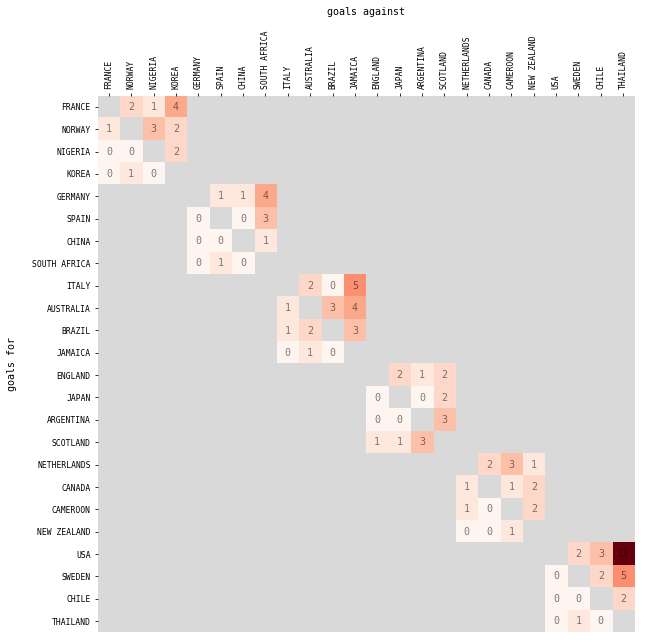

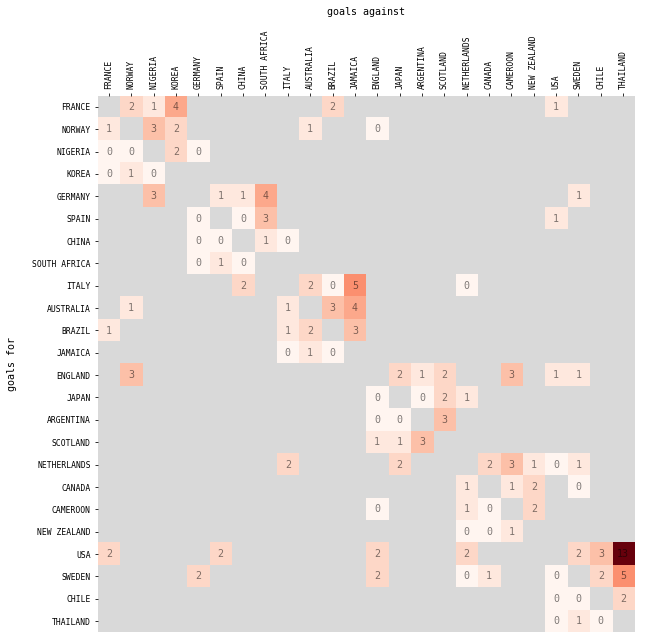

In [37]:
G = utils.get_goal_matrix(m=1,n=3) # the group stage scores
G_all = utils.get_goal_matrix(m=1,n=7) # the group stage scores plus the knockout stage scores
vis.plot_goal_matrix(G)
vis.plot_goal_matrix(G_all)

Below is a sample of the dataset we will work with. The variables are the number of goals scored, number of attempts to score, how many attempts were on-target, and how many attempts were off-target. From those numbers, I also created two variables for convenience, the rate at which shots were on-target in a match and the rate at which the keeper failed to save a shot that was on-target.

In [38]:
df = utils.get_df()
df.sample(10)

,group,team,game,opponent,attempts,on_target,off_target,goals_for,goals_against,on_target_against,on_target_rate,fail_to_save_rate
60,D,JAPAN,3,ENGLAND,16,5,10,0,2,6,0.312500,0.333333
33,B,CHINA,2,SOUTH AFRICA,17,3,9,1,0,1,0.176471,0.000000
24,A,NIGERIA,2,KOREA,12,2,7,2,0,7,0.166667,0.000000
23,F,THAILAND,1,USA,2,2,0,0,13,21,1.000000,0.619048
9,C,ITALY,1,AUSTRALIA,5,3,1,2,1,7,0.600000,0.142857
10,C,BRAZIL,1,JAMAICA,18,6,8,3,0,3,0.333333,0.000000
35,D,SCOTLAND,2,JAPAN,12,4,6,1,2,6,0.333333,0.333333
25,A,KOREA,2,NIGERIA,15,7,3,0,2,2,0.466667,1.000000
81,W,USA,4,SPAIN,12,3,8,2,1,1,0.250000,1.000000
34,D,JAPAN,2,SCOTLAND,18,6,8,2,1,4,0.333333,0.250000


## The MOM Estimator

Expected goals boils down to Arguably, the simplest way to estimate $E[g_{i,j}]$ is to use the Method-of-Moments (MOM) estimator. The way to do this is $E[g_{i,j}] = E[attempts * on\_target\_rate * fail\_to\_save\_rate]$. For simplicity, let's assume that $attempts_i$, $on\_target\_rate_i$, and $fail\_to\_save\_rate_j$ are independent. This is a strong assumption but (spoiler alert!) this is not going to be our final model anyway. Assuming independence, we can separate out the expectation operator for each of the variables.

$E[g_{i,j}] = E[attempts_i] * E[on\_target\_rate_i] * E[fail\_to\_save\_rate_j]$.

The MOM tells us we can just substitute each of these expectations with the empirically observed averages from the data. I built a function to do just that called `EG_matrix()`. The matrix is printed below.

In [39]:
EG_MOM = utils.EG_matrix()
print("\nTrue Expected Goals\n\n",EG_MOM)


True Expected Goals

 [[1.85121283 1.27687016 2.28679231 4.35579488 0.34846359 2.25049402
  0.78404308 1.59712479 0.64299829 2.12345001 1.43741231 3.31870086
  0.74670769 1.28495949 0.99561026 2.46828377 1.09931966 2.03270428
  3.04905642 1.65935043 1.26318052 1.12006154 1.07857778 2.15715556]
 [1.22627287 0.84581913 1.51480766 2.88534792 0.23082783 1.49076309
  0.51936263 1.05796091 0.42593231 1.40660711 0.95216481 2.19836032
  0.49463107 0.85117764 0.6595081  1.63503049 0.72820686 1.3464957
  2.01974355 1.09918016 0.8367509  0.74194661 0.7144671  1.42893421]
 [0.27546296 0.19       0.34027778 0.64814815 0.05185185 0.33487654
  0.11666667 0.23765432 0.09567901 0.31597222 0.21388889 0.49382716
  0.11111111 0.1912037  0.14814815 0.36728395 0.16358025 0.30246914
  0.4537037  0.24691358 0.18796296 0.16666667 0.16049383 0.32098765]
 [1.68751006 1.16395652 2.08457126 3.97061192 0.31764895 2.05148282
  0.71471014 1.45589104 0.58613795 1.93567331 1.31030193 3.02522813
  0.68067633 1.17133052

It's much easier to comprehend this matrix through visualization.  The color in the visualization corresponds to the MOM estimate while the numerical value of the visualization is the MOM estimate rounded to the nearest whole number.

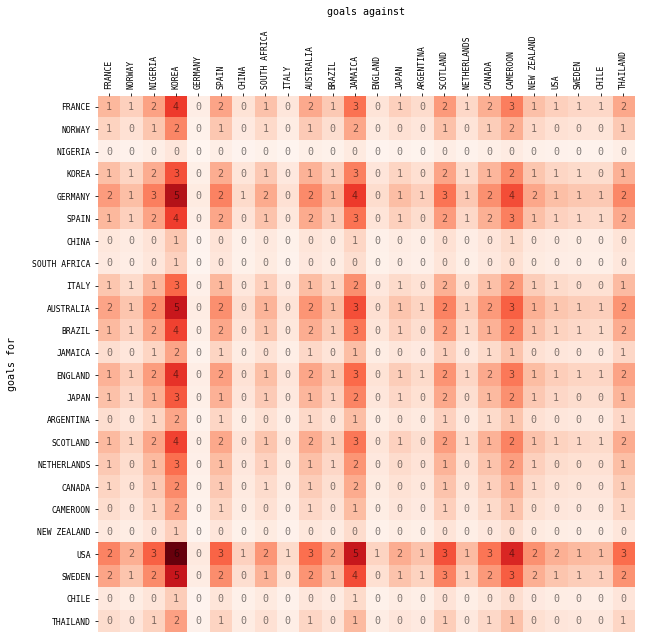

In [40]:
vis.plot_goal_matrix(EG_MOM)

Compare these predictions to the actual observed scores from the tournament. Remember, the model has access to (only) the group stage data.

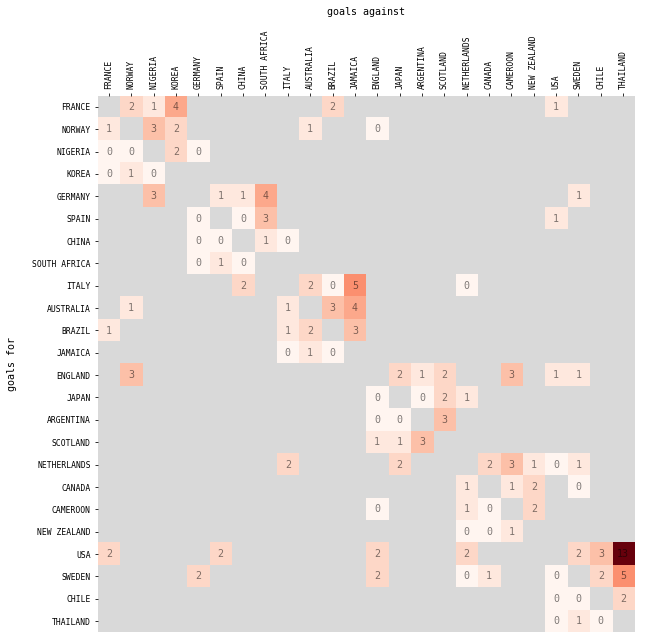

In [41]:
vis.plot_goal_matrix(G_all)

## The Bayesian Approach

The MOM estimator is a simple way to estimate the quality of a team and predict the outcome of a match. With not very much data, we shouldn't place a lot of confidence in the MOM estimator. Scenarios with small amounts of data but some good prior knowledge calls for a more Bayesian approach.

A simple Bayesian model of soccer matches models scored goals as a Poisson distribution, $g_{i,j} \sim Poisson(\theta_{i,j})$. The parameter $\theta_{i,j}$ is a rate parameter which in this example can be interpreted as the average number of goals scored in 90 minutes for team $i$ against team $j$. Note that $\theta_{i,j}$ does not have to be an integer---it can take on any real value greater than zero. We don't really know what $\theta_{i,j}$ is for each team, so maybe we should put a hyperprior on that. How should we choose the hyperparameters? Why not use the MOM estimator for the hyperparameters? What we get is $\theta \sim Normal(\mu, \sigma)$ where $\mu$ is the MOM estimated mean and $\sigma$ is the MOM estimated variance. The full model in Stan is written as follows.

In [42]:
with open('poisson.stan','r') as f:
    print(f.read())

data {
  int<lower=1> N; // number of matches
  int<lower=1> T; // number of teams
  int<lower=1, upper=T> I[N]; // home team for match n
  int<lower=1, upper=T> J[N]; // away team for match n
  matrix<lower=0>[T, T] X; // expected goals for prior
  int<lower=0> Y[T, T]; // goals from matches
}

parameters {
  matrix<lower=0, upper=13>[T, T] theta;
}

model {
  to_vector(theta) ~ normal(to_vector(X),sd(to_vector(X)));
  for (n in 1:N) {
    Y[I[n], J[n]] ~ poisson(theta[I[n], J[n]]);
    Y[J[n], I[n]] ~ poisson(theta[J[n], I[n]]);
  }
}

generated quantities {
  matrix[T, T] EG; // expected goals prediction
  for (i in 1:T) {
    for (j in 1:T) {
      EG[i,j] = poisson_rng(theta[i,j]);
      EG[j,i] = poisson_rng(theta[j,i]);
    }
  }
}




To see how this performs, let's run the model.

In [43]:
# run the model using only group stage data (matches 1-3)
FIT = utils.run_stan_model('poisson.stan',m=1,n=3)

In [44]:
FIT


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_aace7765c73ec40c6ee031186a1d1a5d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1,1]    1.95    0.02    0.9   0.31   1.29   1.92   2.56   3.79   3023    1.0
theta[2,1]    1.36    0.01   0.68   0.27   0.84   1.28    1.8   2.83   4401    1.0
theta[3,1]    0.58  7.9e-3   0.48   0.02    0.2   0.46   0.83   1.81   3735    1.0
theta[4,1]    1.13    0.01   0.73   0.06   0.55   1.02   1.61   2.78   4335    1.0
theta[5,1]    2.47    0.01   0.98   0.63    1.8   2.44   3.13   4.44   4280    1.0
theta[6,1]    1.92    0.01   0.92    0.3   1.25    1.9   2.54   3.83   3959    1.0
theta[7,1]    1.07    0.01   0.71   0.06   0.52   0.95   1.54   2.65   4385    1.0
theta[8,1]    1.03    0.01    0.7   0.05   0.49   0.92   1.47   2.65   4029    1.0
theta[9,1]    1.62    0.

Convergence and Rhat look good. Let's see how the predictions turned out.

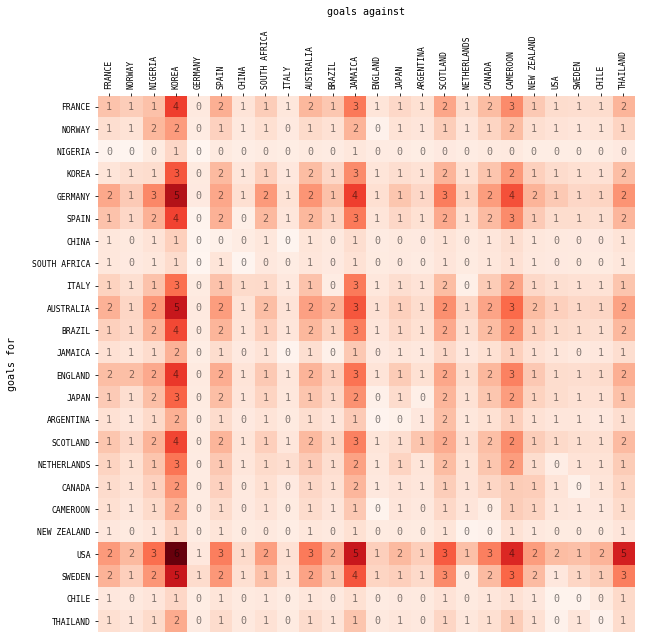

In [45]:
EG_poisson = FIT.extract(pars=['EG'])['EG']
vis.plot_goal_matrix(EG_poisson.mean(axis=0))

Again, compare with the actual observed scores.

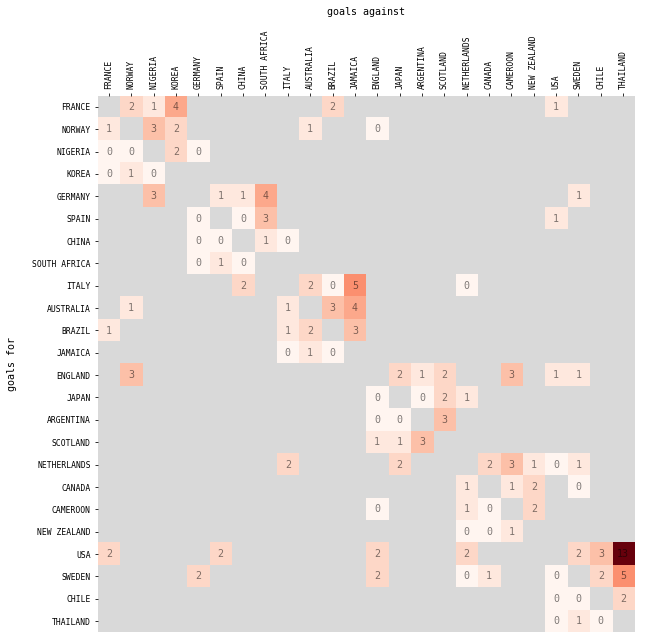

In [46]:
vis.plot_goal_matrix(G_all)

The predictions looks very similar to the MOM estimator matrix. That makes sense because we used the MOM estimator to inform the hyperprior for our Poisson model. However, it still looks like not much of an improvement. Can we do better? (We can.)

## A More Structural Poisson Model

One way we can improve this model is by deconstructing the $\theta_{i,j}$ into it's various components. By adding structure to the model, we will improve estimation. Recall how we computed the MOM estimate:

$E[g_{i,j}] = E[attempts_i] * E[on\_target\_rate_i] * E[fail\_to\_save\_rate_j]$.

Let's improve our model by giving each of these independent variables its own hyperprior. For simplicity, we can assign a normal distribution to the number of attempts with the mean and variance computed from the empirical data as before. This is reasonable.

To model the on-target and failure-to-save rates, we can use the beta distribution. One way to interpret the two parameters of a beta distribution is as "pseudocounts" for the number of successes and failures respectively of a Bernoulli process.

$rate \sim Beta(\alpha, \beta)$

Thus, we can model the on-target and failure-to-save rates with a beta distribution. Using the on-target rate as an example, the hyperparameter $\alpha$ is chosen to be equal to the number of shots on-target + 1. Likewise, the hyperparameter $\beta$ is chosen to be equal to the number of shots off-target + 1. The addition of the ones has to do with the interpretation of the $Beta(1,1)$ distribution, which is the same as a uniform distribution between 0 and 1. In other words, we know that shots can be on-target and they can be off-target. The failure-to-save rate hyperparameters are chosen similarly with a success being the number of goals scored against the opponent and a failure being the number of shots on-target minus the number of goals scored against the opponent.

Let's see how this model fares.

In [47]:
with open('poisson2.stan','r') as f:
    print(f.read())
    
# use data from group stage only (matches 1-3)
FIT2 = utils.run_stan_model('poisson2.stan',m=1,n=3)
FIT2

data {
  int<lower=1> N; // number of matches
  int<lower=1> T; // number of teams
  int<lower=1, upper=T> I[N]; // home team for match n
  int<lower=1, upper=T> J[N]; // away team for match n
  real<lower=0> X1[2,T]; // attempts mean and variance
  real<lower=0> X2[2,T]; // on/off target pseudocounts
  real<lower=0> X3[2,T]; // save/goal pseudocounts
  int<lower=0> Y[T, T]; // goals from matches
}

parameters {
  real<lower=0> attempts[T]; // attempts at goal
  real<lower=0, upper=1> sot_rate[T]; // shot on target rate
  real<lower=0, upper=1> fts_rate[T]; // fail to save rate
}

model {
  attempts ~ normal(X1[1], X1[2]);
  sot_rate ~ beta(X2[1], X2[2]);
  fts_rate ~ beta(X3[1], X3[2]);
  for (n in 1:N) {
    Y[I[n], J[n]] ~ poisson(attempts[I[n]]*sot_rate[I[n]]*fts_rate[J[n]]);
    Y[J[n], I[n]] ~ poisson(attempts[J[n]]*sot_rate[J[n]]*fts_rate[I[n]]);
  }
}

generated quantities {
  matrix[T, T] EG; // expected goals prediction
  for (i in 1:T) {
    for (j in 1:T) {
      EG[i,j] = 


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_5f7680b71b0bbd9eaceb12f7e4e2a56a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
attempts[1]   17.51    0.07   5.63   8.18  13.48  16.89  20.97  30.29   7057    1.0
attempts[2]   10.43    0.04    3.6   4.36   7.83   10.1  12.58  18.44   7111    1.0
attempts[3]    14.7    0.14   10.0    2.5   7.49   12.4  19.35   39.4   5388    1.0
attempts[4]    5.43    0.06   4.28   0.63   2.46   4.34   7.27  16.34   5027    1.0
attempts[5]   18.42    0.08   6.12   8.69   14.0  17.68  21.94  32.27   5913    1.0
attempts[6]   15.24     0.1    7.6   4.43   9.71  13.92  19.31  33.59   6295    1.0
attempts[7]   11.61    0.16   10.6   1.13   4.52   8.62  15.28  40.69   4236    1.0
attempts[8]    5.74    0.03    2.1   1.85   4.23   5.66   7.13  10.07   5523    1.0
attempts[9]   1

Convergence and Rhat look great and the model finished much faster which likely indicates that we probably have a better model. Let's look at the predictions.

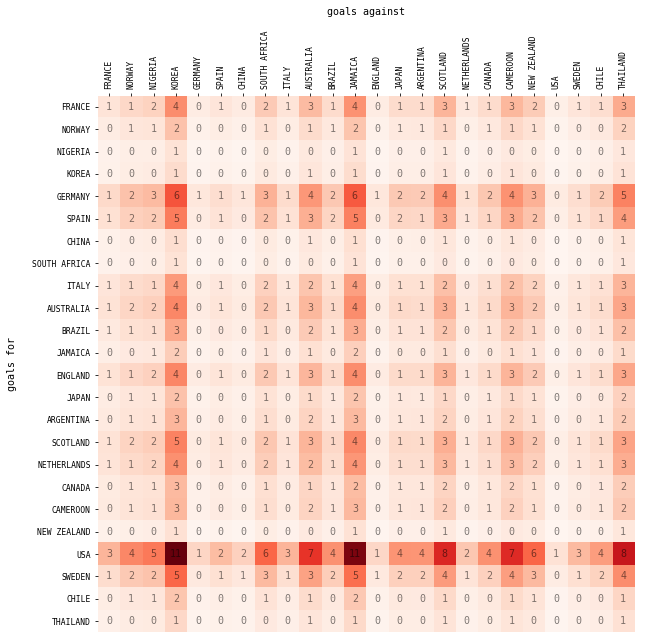

In [48]:
EG_poisson2 = FIT2.extract(pars=['EG'])['EG']
vis.plot_goal_matrix(EG_poisson2.mean(axis=0))

Compare to the actual observed goals.

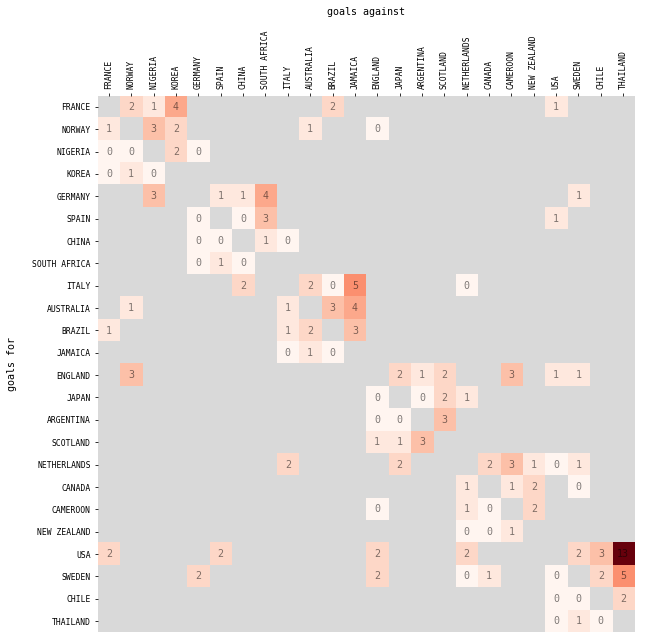

In [49]:
vis.plot_goal_matrix(G_all)

These predictions are much better than those of the previous two models. By adding structure to the model, we were able to improve the predictions.